# <a style="color:white;background-color:black"> Exploration 10. 인공지능으로 세상에 없던 새로운 패션 만들기 </a>

# 프로젝트: CIFAR-10 이미지 생성하기

## \# 평가 루브릭

#### (1) GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
-> 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.

#### (2) 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
-> gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.

#### (3) 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
-> 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

## STEP 1. 작업환경 구성하기

작업 환경 세팅! (필요한 패키지들 import)

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

ver = 0
print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

keras의 데이터셋에서 ```fashion_mnist``` 데이터를 불러온다.  
이 때, 분류 문제와는 달리 레이블이 필요하지 않으므로, y데이터는 언더바(\_) 처리한다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

32x32 사이즈이며 이미지 파일이므로, 0~255의 픽셀값을 가질것이다. 확인해보자!

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


중간값을 0으로 맞추기위해 픽셀값을 -1에서 1로 정규화해준다!

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


데이터셋의 shape 확인

In [5]:
train_x.shape

(50000, 32, 32, 3)

CNN의 경우 채널 수에 대한 차원이 필요함.  
FASHION MNIST는 흑백이미지 이므로 채널수 1을 shape 마지막에 추가해준다.

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

첫 번째 데이터를 꺼내서 실제로 확인해보자!

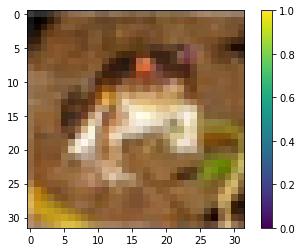

In [7]:
plt.imshow((train_x[0].reshape(32, 32, 3)+1)/2)
plt.colorbar()
plt.show()

시각화 자료에서 확인 가능하듯이, 픽셀값이 정규화되어 -1에서 1사이에 분포되어있다.

또 어떤 이미지가 있는지 10개 확인!!

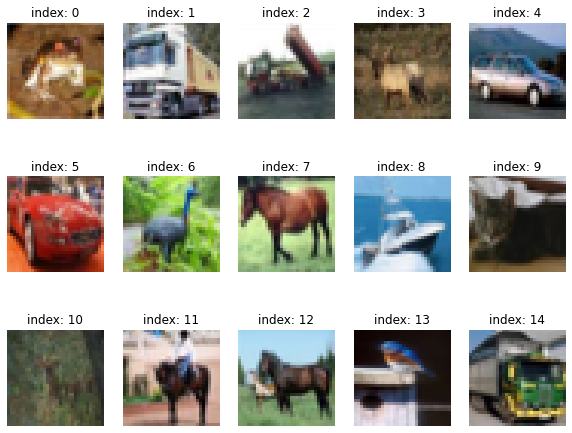

In [8]:
plt.figure(figsize=(10, 8))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow((train_x[i].reshape(32, 32, 3)+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

이번에는 전체 데이터 중에서 랜덤하게 25개의 이미지를 출력해보자!

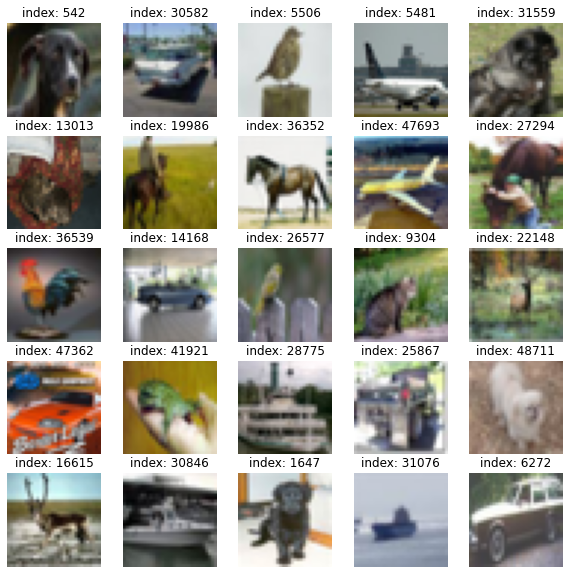

In [9]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32, 32, 3)+1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

tensorflow의 dataset을 이용해 데이터를 준비한다.  
우선 자주 쓰이는 변수를 정의한다.  
```BUFFER_SIZE```는 전체 데이터를 섞기 위해 50000으로 하고, ```BATCH_SIZE```는 일반적으로 쓰이는 256으로 설정한다.

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train 데이터셋을 생성해준다.  
자료를 섞고, 배치 사이즈에 맞게 나눠준다.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기(DCGAN)

Keras Sequential API를 활용하여 생성자 구현하기

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))
    
    # Third: Conv2DTranspose layer
#    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#    model.add(layers.BatchNormalization())
#    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # tanh 쓴 이유:  -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

```Conv2DTransepose```는 일반적인 ```Conv2D```와 달리 이미지 사이즈를 키운다.  
최종 사이즈인 (32, 32, 3)은 준비한 데이터셋의 shape과 같다.

정의된 함수를 이용해 generator 변수를 생성하고, 모델의 summary를 확인!

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

```tf.random.normal```을 이용하여 ```shape=(1, 100)```의 랜덤 노이즈 벡터를 생성하고 결과를 만들어보자!  
학습이 안된 상태이기에 의미는 없을 것이다.

In [14]:
noise = tf.random.normal([1, 100])

생성자 모델에 노이즈 입력값을 주고 모델을 호출하면 바로 결과를 볼 수 있다.  
단, 학습 단계가 아니므로 ```training=False```를 설정해주어야 한다.

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

시각화하여 출력해보자!  
matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 함

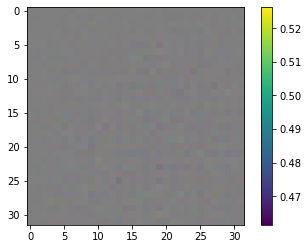

In [16]:
plt.imshow((generated_image[0, :, :, :]+1)/2)
plt.colorbar()
plt.show()

노이즈가 잘 생성되었다!!!

## STEP 4. 판별자 모델 구현하기(DCGAN)

입력은 (28, 28, 1)이고, 출력은 진짜인지 가짜인지 판단하는 정도를 나타내는 하나의 숫자이다\!  
모델은 함수로 구현한다.  
생성자와는 다르게 이미지 크기를 줄여나가는 ```Conv2D```를 사용한다

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
#    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#    model.add(layers.LeakyReLU())
#    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

정의된 함수를 이용해 ```discriminator```를 생성하고, 모델의 summary를 확인!!

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

앞에서 만들었던 랜덤 노이즈 이미지를 입력으로 결과를 나타내면?

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00134879]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

판별자가 이미지가 리얼인지 페이크인지 2개의 클래스내에서 판단하기에 이진 교차 엔트로피(binary cross entropy)를 사용  
* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
* 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

-> 결국 판별자의 판별값이 각각의 loss에 사용됨

from_logits를 True로 설정  
-> tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이므로,  
   해당 설정으로 함수 내부에서 sigmoid를 통해 값을 0~1 사이로 만들어줌.

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용
* fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
* real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

#### loss 함수 만들기

```generator_loss``` 함수 만들기

one_like -> 해당 벡터와 크기는 같으면서 값으로 1만 가지고 있는 벡터를 생성  
생성자에서는 생성한 이미지의 판별값이 리얼이라고 판단(판단값: 1) 되어야 하기때문

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

```discriminator_loss``` 함수 만들기

zero_like -> 해당 벡터와 크기는 같으면서 값으로 0만 가지고 있는 벡터를 생성  
리얼 이미지의 판별값은 1에 가까워지게 하고, 생성 이미지의 판별값은 0에 가까워지게 해야함

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator accuracy 함수 만들기  
판별자가 얼마나 정확히 판별하는지 accuracy로 확인헤보는 것이 중요함  
real accuracy와 fake accuracy가 모두 0.5에 수렴하는 것이 가장 이상적임

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

(tf.math.greater_equal(real_output, tf.constant([0.5])  
-> 각 원소가 0.5 이상인지 아닌지 판별  

tf.cast( (\#), tf.float32)  
-> (\#)의 결과가 True이면 1.0, False이면 0.0으로 변환  

tf.reduce_mean( (\#) )  
-> (\#)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산

#### 최적화 함수 만들기

ADAM을 사용할 예정이며,  
생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.  
learning rate는 0.0001을 사용

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

매번 학습이 어떻게 되고 있는지 확인하기 위해 생성자가 생성한 샘플을 확인할 예정  
100차원의 노이즈를 16개 생성한다.

In [25]:
noise_dim = 100
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([25, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

한 번의 스텝을 진행하는 함수를 생성  
데코레이터인 ```@tf.function```를 활용하여 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기!  
위에서 생성한 ```seed``` 활용

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), ver, epoch, it))

    plt.show()

train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 보자!

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_{}/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), ver, epoch))
    plt.show()

정기적으로 모델을 저장하기 위한 checkpoint를 만들어보자!!

In [32]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_'+str(ver)+'/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

학습을 진행하는 함수를 정의하자!  
```train_step```과 ```generate_and_save_images()```, ```draw_train_history()```, ```checkpoint```을 모아서 만든다.

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

GPU를 사용하지 않으면 매우매우매우 느리다!!!

In [31]:
save_every = 5 # 모델을 저장하는 간격 파라미터
EPOCHS = 200 # 전체 EPOCH수 파라미터

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

드디어 DCGAN 학습을 시작해보자!

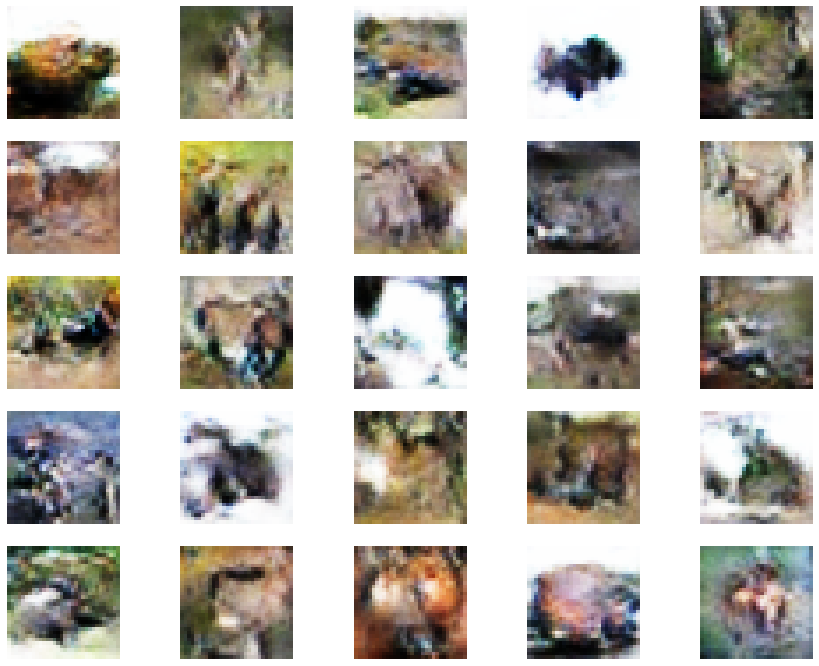

Time for training : 5360 sec


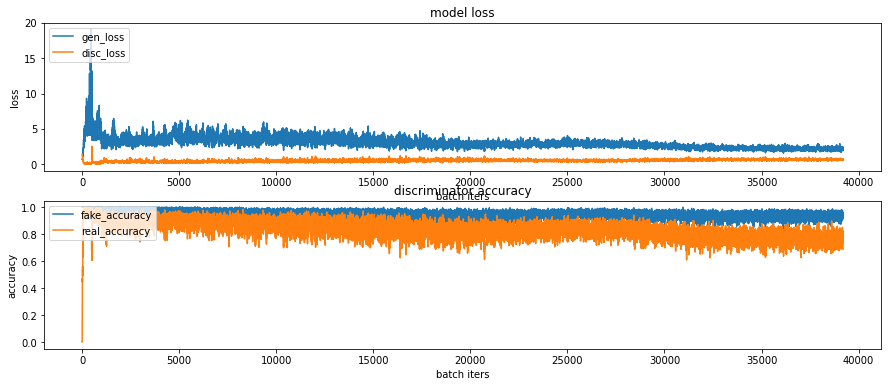

CPU times: user 1h 31min 16s, sys: 4min 18s, total: 1h 35min 34s
Wall time: 1h 29min 22s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

학습이 완료되었다.  
disciminator의 loss는 0에 근접하지만 generation의 loss는 그래프 상 2~3 사이로 추정된다.  
점점 줄어들고 있는 모양새이긴 하지만 거의 수렴하며 진동폭도 작아졌다.  

accuracy의 경우 real accuracy는 조금씩 떨어지며 0.8정도를 보이고, 계속해서 조금씩 낮아지는 모습이다.  
그러나 fake accuracy의 경우 떨어지는 폭이 굉장히 작으며 0.9 정도에 머물러 있다.


학습과정을 시각화하여 gif 파일로 나타내보자~

In [37]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_{}/cifar10_dcgan.gif'.format(ver)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_{}/generated_samples/sample*.png'.format(os.getenv('HOME'), ver))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 2273197 Feb 10 09:50 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


전혀 어떤 object라고 하기 어려운 형태로만 출력이 된다.  

![cifar10_dcgan_0-Copy1](https://user-images.githubusercontent.com/97072815/153894688-49d2984a-b173-4d89-ace4-f754215cd6a4.gif)

## STEP 8. (optional) GAN 훈련 과정 개선하기

#### 컨볼루션 레이어를 추가하여 아주 작은 특징까지 찾아보자!

In [45]:
def make_generator_model_plus():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # 레이어를 추가하기 위해 입력 shape부터 바꿔줬다. 4x4x256에서 2x2x512로 변경
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    # 시작 shape이 (2, 2, 512)가 되도록 reshape 해준다
    model.add(layers.Reshape((2, 2, 512)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # tanh 쓴 이유:  -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

generator = make_generator_model_plus()

In [46]:
def make_discriminator_model_plus():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    # 필터수 512개인 레이어를 추가 
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model_plus()

In [47]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              204800    
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 4, 4, 256)        

In [48]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)        

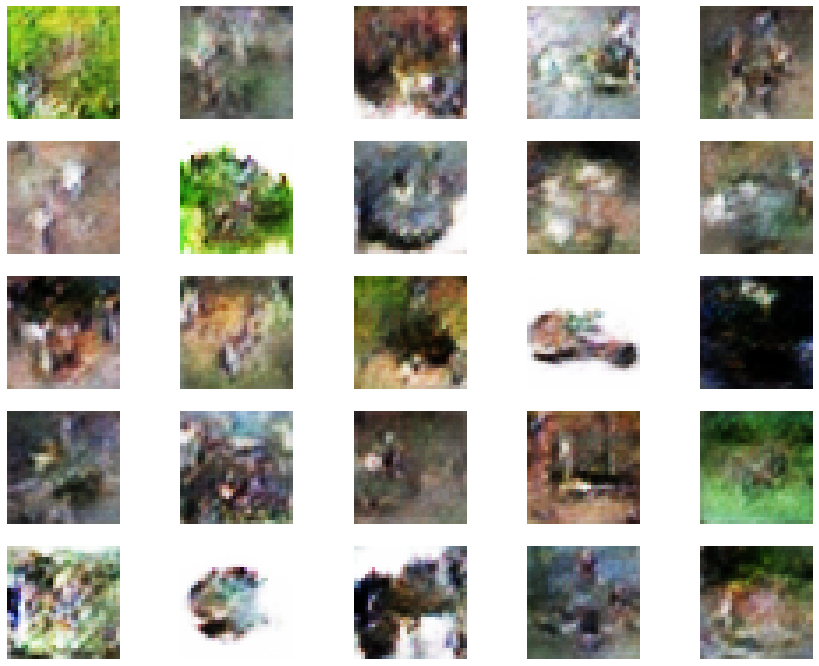

Time for training : 8189 sec


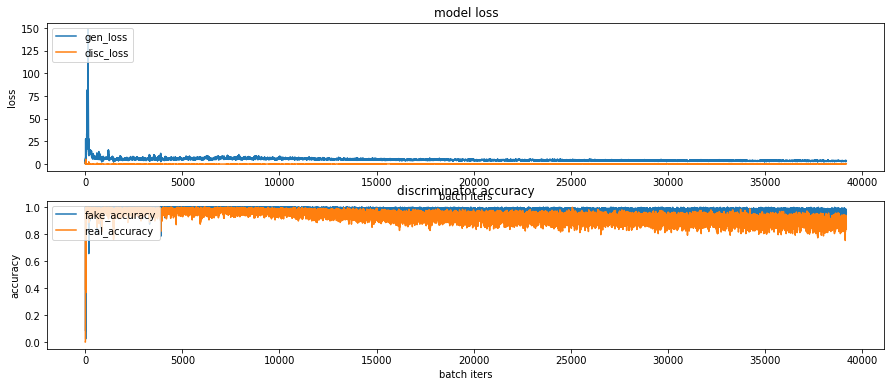

CPU times: user 2h 18min 2s, sys: 4min 36s, total: 2h 22min 39s
Wall time: 2h 16min 31s


In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

오히려 generator의 loss가 큰 폭으로 오른 모습을 보인다.  
real accuracy는 비슷한 양상이며 fake accuracy는 소폭 낮아진 모습을 보인다.  
생성한 이미지들은 무엇이라고 하긴 어렵지만 그래도 뭔가 형태가 조금씩 나타나는 듯한 모습이다.

#### 배치사이즈를 줄여보자

In [49]:
BATCH_SIZE = 128
ver = 1

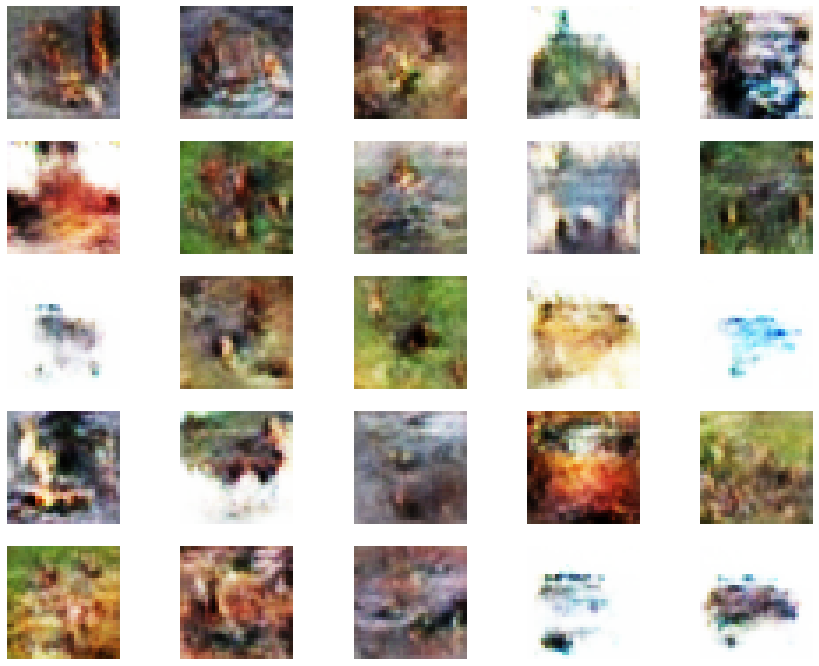

Time for training : 6131 sec


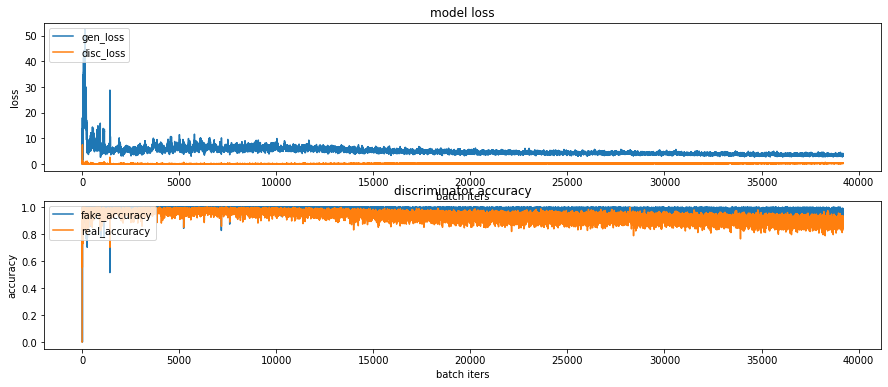

CPU times: user 1h 49min 31s, sys: 6min 48s, total: 1h 56min 19s
Wall time: 1h 42min 13s


In [50]:
%%time
train(train_dataset, EPOCHS, save_every)

loss와 accuracy, 생성한 이미지 모두 이전과 비슷한 모습을 보인다.

#### Optimizer 조절 및 generator의 reshape 레이어 다음에 dropout 추가

In [40]:
def make_generator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((2, 2, 512)))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # tanh 쓴 이유:  -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

generator = make_generator_model_2()

In [41]:
def make_discriminator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model_2()

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [49]:
BATCH_SIZE = 512
ver = 0

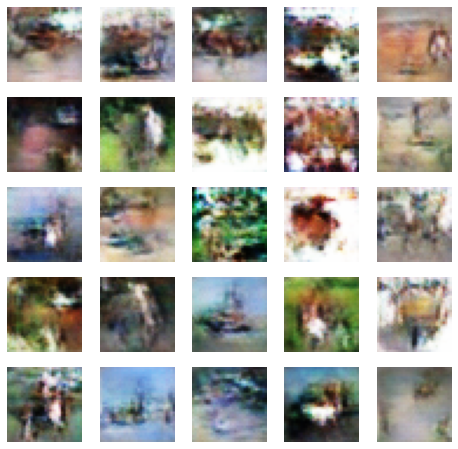

Time for training : 12734 sec


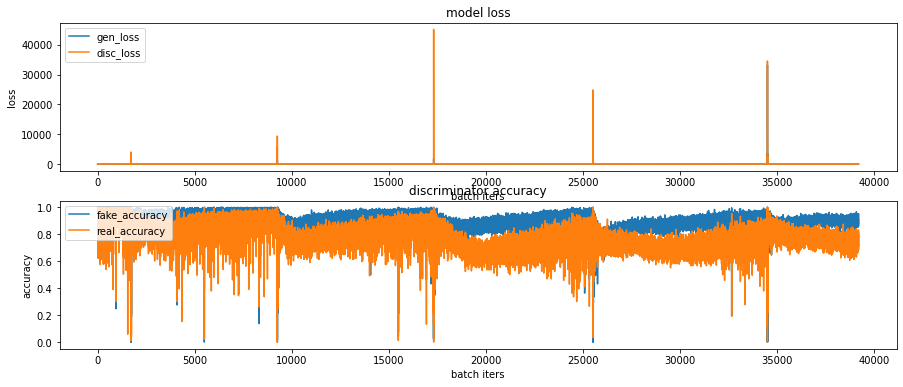

CPU times: user 3h 32min 32s, sys: 4min 11s, total: 3h 36min 44s
Wall time: 3h 32min 16s


In [51]:
%%time
train(train_dataset, EPOCHS, save_every)

옵티마이저를 조절해서 그런지 loss는 한번씩 굉장히 높게 나타나지만 거의 0에 가깝고,  
accuracy도 loss가 한번씩 높아질 때마다 대폭 감소하는 모습을 보인다.  
결국 real accuracy는 0.8보다 조금 낮은 값을 나타내고, fake accuracy는 0.8보다 조금 높은 값을 나타낸다.  
양상을 보아 더 많은 epoch를 진행하면 더 낮아질 것으로 예상된다.

#### generator의 flatten 레이어 다음에 dropout 레이어를 추가하고, 배치 사이즈를 512로 변경(한 번에 더 많은 이미지를 참고하도록 하기위해)

In [32]:
def make_generator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((2, 2, 512)))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # tanh 쓴 이유:  -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

generator = make_generator_model_3()

In [33]:
def make_discriminator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    # Dropout 추가!
    model.add(layers.Dropout(0.4))

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model_3()

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [35]:
BATCH_SIZE = 512
ver = 1

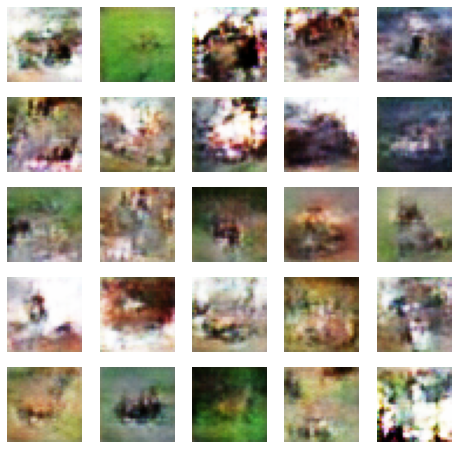

Time for training : 12660 sec


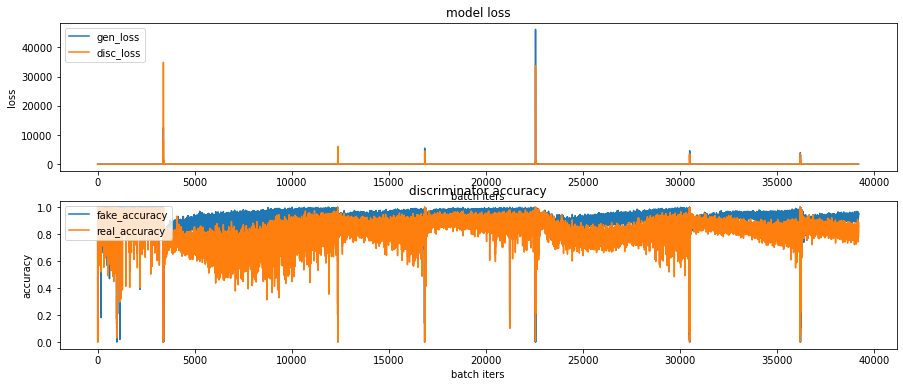

CPU times: user 3h 31min 52s, sys: 4min 13s, total: 3h 36min 5s
Wall time: 3h 31min 2s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

![cifar10_dcgan](https://user-images.githubusercontent.com/97072815/154029548-4de2c5ce-5d08-4fb2-b351-bbec7f73c943.gif)

이전의 모델과 크게 다르지 않은 가운데,  
discriminator의 loss가 0에 가까운 모습을 보여준다.  
accuracy의 경우 real accuracy는 0.6\~0.8을 진동하고, fake accuracy는 0.8\~0.9를 진동하며 점점 작아지고 있다.  

생성된 이미지를 시각화한 모습에서도 이전보다 조금은 더 다른 형상들이 나타나는 듯해 보인다.

---

# 회고

\# 노드의 내용을 충실히 따라하며 판별자와 생성자를 모델링하고 GAN 학습을 완료하였다.  
생성된 이미지는 전혀 의미가 없지는 않다는 데 의의를 두며, accuracy의 경우 계속해서 우하향하는 모습을 보인다.  

\# 이전에 Style Transfer 저자의 코드를 이용해서 프로젝트를 해보려고 한 경험이 있는데,  
지금 생각해보니 모델 구조를 하나도 이해하지 못하고 무언가를 하려고 했었던것 같다.  
이제서야 GAN이라는 것에 대해 조금 이해한 것 같다.

\# 좋은 성능으로 이미지를 생성하기 위해서는 노드에서 소개된 DCGAN과 같은 초기 모델 보다는 최신 모델을 활용해야 할 것 같다.  
많은 기법들이 쏟아져 나왔고 성능면에서도 상당한 발전을 이뤘다.  
우선은 cifar-10의 경우 이미지의 해상도가 매우 낮은데 이미지의 구조는 복잡하다 보니 분류는 제대로 될 지라도, 특징을 이용해 생성하는데는 한계가 있는것 같다.  
고해상도 이미지를 이용하여 해당 모델을 학습했을 때, 어떤 결과를 나타낼지 궁금하다.